In [0]:
def extract_data(url, fname=None, dest=None, force_download=False):
    from urllib.request import urlopen
    from zipfile import ZipFile
    import os
    import shutil
    from pathlib import Path
    filename = url.rpartition('/')[2]
    foldername = filename.split('.')[0]
    if os.path.exists(f'{dest}/{foldername}'):
        print('Already Downloaded')
        if force_download:
            print('Removing Old Downloaded')
            shutil.rmtree(f'{dest}/{foldername}')
        else:
            return Path(f'{dest}/{foldername}')
    print('Downloading from remote server')
    response = urlopen(url)
    if dest is None: dest = '.'
    tmpzip = open(f'{dest}/{filename}', 'wb')
    tmpzip.write(response.read())
    tmpzip.close()
    if (filename.endswith("zip")):
        zf = ZipFile(f'{dest}/{filename}')
        zf.extractall(path = dest)
        zf.close()
    elif (filename.endswith("tar.gz") or filename.endswith("tgz")):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall(path = dest)
        tar.close()
    elif (filename.endswith("tar")):
        tar = tarfile.open(filename, "r:")
        tar.extractall(path = dest)
        tar.close()
    os.remove(f'{dest}/{filename}')
    return Path(f'{dest}/{foldername}')

In [0]:
# def annealing_cos(start:Number, end:Number, pct:float)->Number:
#     "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
#     cos_out = np.cos(np.pi * pct) + 1
#     return end + (start-end)/2 * cos_out

In [0]:
from keras.callbacks import *
class CyclicLR(Callback):
    def __init__(self, base_lr=1e-7, max_lr=1e-2, step_size=200,
                 mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_mode = scale_mode
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2. ** (x-1))
            elif self.mode == 'circular':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
        self._reset()
        
    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
            
        if new_max_lr != None:
            self.max_lr = new_max_lr
            
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.basr_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

Using TensorFlow backend.


In [0]:
from tqdm import tqdm
class TTA_ModelWrapper():
    def __init__(self, model):
        self.model = model

    def _predict(self, inputs):
        tta_steps = 10
        predictions = []
        train_datagen = ImageDataGenerator(
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            rotation_range=10.,
            fill_mode='reflect',
            width_shift_range = 0.1, 
            height_shift_range = 0.1)

        train_datagen.fit(inputs)
        
        for i in range(tta_steps):
            preds = self.model.predict(train_datagen)
            predictions.append(preds)
        pred = np.mean(predictions, axis=0)
        return pred
    
    def predict(self, x):
        prediction = []
        for data in tqdm(train_generator):
            inputs, labels = data
            prediction.extend(self._predict(inputs))
        return prediction
        
    def _expand(self, x):
        return np.expand_dims(np.expand_dims(x, axis=0), axis=3)

In [0]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback
import math
from keras.models import clone_model, load_model

class LRFinder:
    def __init__(self, model, train, batch_size):
        model_copy = clone_model(model)
        model_copy.set_weights(model.get_weights())
#         import pdb; pdb.set_trace();
        self.model = model_copy
        self.model.compile(optimizer = model.optimizer, loss = model.loss, metrics = model.metrics)
#         self.model = model
#         self.model.save('model1.h5')
        self.train = train
        self.lr_finder = LRFinderHelper(self.train.n // batch_size)
    
    def find_lr(self):
        self.model.fit_generator(self.train, self.train.n // batch_size, epochs=1, workers=4,
                    callbacks=[self.lr_finder])
        
    def get_data(self):
        return self.lr_finder.history     


class LRFinderHelper(Callback):
    def __init__(self, num, min_lr=1e-8, max_lr=10, beta=0.98):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.beta = beta
        self.lr = min_lr
        self.avg_loss = 0.
        self.best_loss = 0.
        self.batch_num = 0
        self.losses = []
        self.log_lrs = []
        self.batch_num = 0
        self.history = {}
        self.num = num
        self.mult = (self.max_lr / self.min_lr) ** (1/self.num)

    def on_train_begin(self, logs=None):
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.lr)
    
#     def on_train_end(self, logs=None):
#         logs = logs or {}
#         self.model= load_model('model1.h5')
        
    def on_batch_end(self, epoch, logs=None):
#         import pdb; pdb.set_trace();
        self.batch_num += 1
        self.history.setdefault('lr', []).append((K.get_value(self.model.optimizer.lr)))
        self.history.setdefault('iterations', []).append(self.batch_num)
        logs = logs or {}
        for k, v in logs.items():
            if k == 'loss':
                self.avg_loss = self.beta * self.avg_loss + (1-self.beta) * v
                smoothed_loss = self.avg_loss / (1 - self.beta**self.batch_num)
                self.history.setdefault(k, []).append(smoothed_loss)
            else:
                self.history.setdefault(k, []).append(v)
        self.lr *= self.mult
        K.set_value(self.model.optimizer.lr, self.lr) 
        
         
        

## Dogs vs Cats

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

In [0]:
path = extract_data('http://files.fast.ai/data/dogscats.zip', dest='sample_data')
list(iter(path.iterdir()))

Already Downloaded


[PosixPath('sample_data/dogscats/models'),
 PosixPath('sample_data/dogscats/valid'),
 PosixPath('sample_data/dogscats/train'),
 PosixPath('sample_data/dogscats/sample'),
 PosixPath('sample_data/dogscats/test1')]

In [0]:
train_data_dir = path/'train'
validation_data_dir = path/'valid'

In [0]:
sz=224
batch_size=64

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True
                                   )

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: 
    layer.trainable = False

In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [0]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

sgd = optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
lrf = LRFinder(model, train_generator, batch_size)

In [0]:
lrf.find_lr()

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
359/359 [==============================] - 237s 661ms/step - loss: 1.6370 - acc: 0.6840


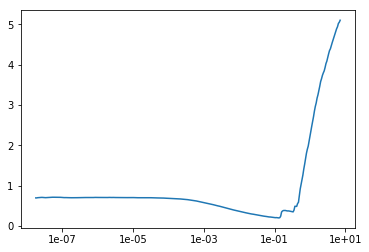

In [0]:
fig, ax = plt.subplots(1,1)
ax.plot(lrf.get_data()['lr'][10:-5],lrf.get_data()['loss'][10:-5])
ax.set_xscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [0]:
sgd = optimizers.SGD(lr = 1e-02, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

# model.fit_generator(train_generator, train_generator.n // batch_size, epochs=2, workers=4,
#                     validation_data=valid_generator, validation_steps=valid_generator.n // batch_size,
#                     )

In [0]:
%%time
clr_triangular = CyclicLR(mode='triangular')
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=5, workers=4,
                    validation_data=valid_generator, validation_steps=valid_generator.n // batch_size,
                    callbacks=[clr_triangular])

Epoch 1/5
  2/359 [..............................] - ETA: 20:17 - loss: 0.6795 - acc: 0.6172

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298100). Check your callbacks.
  % delta_t_median)


359/359 [==============================] - 241s 670ms/step - loss: 0.1264 - acc: 0.9480 - val_loss: 0.0462 - val_acc: 0.9834
Epoch 2/5
359/359 [==============================] - 230s 640ms/step - loss: 0.0545 - acc: 0.9792 - val_loss: 0.0637 - val_acc: 0.9788
Epoch 3/5
359/359 [==============================] - 227s 633ms/step - loss: 0.0471 - acc: 0.9810 - val_loss: 0.0506 - val_acc: 0.9814
Epoch 4/5
359/359 [==============================] - 230s 640ms/step - loss: 0.0423 - acc: 0.9844 - val_loss: 0.0914 - val_acc: 0.9747
Epoch 5/5
359/359 [==============================] - 234s 653ms/step - loss: 0.0382 - acc: 0.9859 - val_loss: 0.0528 - val_acc: 0.9819
CPU times: user 35min 51s, sys: 39.2 s, total: 36min 31s
Wall time: 19min 23s


In [0]:
# %%time
# clr_triangular = CyclicLR(mode='triangular', max_lr=1e-2)
# model.fit_generator(train_generator, train_generator.n // batch_size, epochs=2, workers=4,
#                     validation_data=valid_generator, validation_steps=valid_generator.n // batch_size,
#                     callbacks=[clr_triangular])

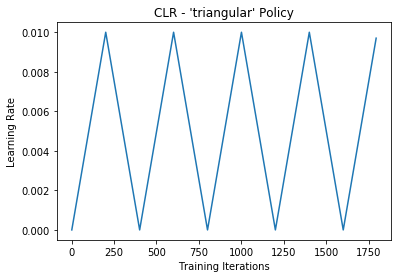

In [0]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [0]:
model.evaluate_generator(valid_generator, steps=valid_generator.n // batch_size)

[0.05487297968798238, 0.981404958677686]

In [0]:
model.predict_generator(valid_generator, steps=valid_generator.n // batch_size, steps=valid_generator.n // batch_size)

array([[0.9999998 ],
       [0.99999994],
       [0.9999627 ],
       ...,
       [0.99999833],
       [0.99852026],
       [0.99999166]], dtype=float32)

In [0]:
list(next(iter(valid_generator)))[0][0].shape

(224, 224, 3)

In [0]:
test_file = list(next(iter(valid_generator)))[0][0]

test_file = np.expand_dims(test_file, axis=0)

In [0]:
model.predict(test_file)

array([[6.22008e-09]], dtype=float32)

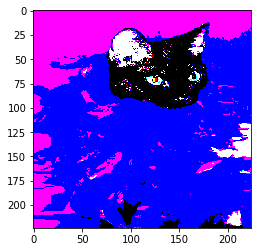

In [0]:
plt.imshow(test_file[0]);

In [0]:
valid_generator.filepaths;

In [0]:
img = plt.imread('sample_data/dogscats/valid/cats/cat.1001.jpg')

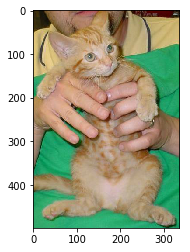

In [0]:
plt.imshow(img)

In [0]:
model.predict(np.expand_dims(img, 0))

array([[3.323685e-05]], dtype=float32)

In [0]:
img2 = plt.imread('sample_data/dogscats/valid/dogs/dog.10005.jpg')

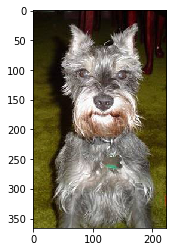

In [0]:
plt.imshow(img2)

In [0]:
model.predict(np.expand_dims(img2, 0))

array([[0.9985207]], dtype=float32)

In [0]:
i = 1
for data in valid_generator:
    if i >= 2: break
    i += 1
    j = 1
    for x in data[0]:
        if i >= 10: break
        print(x.shape)

In [0]:
from tqdm import tqdm
class TTA_ModelWrapper():
    def __init__(self, model):
        self.model = model

    def _predict(self, inputs):
        tta_steps = 10
        predictions = []
        train_datagen = ImageDataGenerator(
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            rotation_range=10.,
            fill_mode='reflect',
            width_shift_range = 0.1, 
            height_shift_range = 0.1)

        train_datagen.fit(inputs)
        
        for i in range(tta_steps):
            preds = self.model.predict(inputs)
            predictions.append(preds)
        pred = np.mean(predictions, axis=0)
        return pred
    
    def predict(self, x):
        prediction = []
        for data in tqdm(train_generator):
            inputs, labels = data
            prediction.extend(self._predict(inputs))
        return prediction
        

## Need to check this

In [0]:
tta_model = TTA_ModelWrapper(model)

predictions = tta_model.predict(valid_generator)

In [0]:
multipliers = {'dense_1': 0.5, 'dense_2': 0.4}
opt = LearningRateMultiplier(SGD, lr_multiplier=multipliers, lr=0.001, momentum=0.9)